<a href="https://colab.research.google.com/github/sway-am/interpretability_PV_detection/blob/main/SHAP_on_PV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! ls

gdrive	sample_data


In [6]:
%cd /content/gdrive/MyDrive/project_folder2

/content/gdrive/MyDrive/project_folder2


In [13]:
! git clone https://github.com/zae-bayern/elpv-dataset.git

Cloning into 'elpv-dataset'...
remote: Enumerating objects: 2695, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2695 (delta 2), reused 1 (delta 1), pack-reused 2691
Receiving objects: 100% (2695/2695), 90.79 MiB | 15.71 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (2629/2629), done.


In [14]:
#code copied from the utils file
from PIL import Image
import numpy as np
import os


def load_dataset(fname=None):
    if fname is None:
        # Assume we are in the utils folder and get the absolute path to the
        # parent directory.
        __file__ = '/content/gdrive/MyDrive/project_folder2/elpv-dataset/doc'
        fname = os.path.abspath(os.path.join(__file__,
                                             os.path.pardir))
        fname = os.path.join(fname, 'labels.csv')

    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=[
                         'path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    def load_cell_image(fname):
        with Image.open(fname) as image:
            return np.asarray(image)

    dir = os.path.dirname(fname)

    images = np.array([load_cell_image(os.path.join(dir, fn))
                       for fn in image_fnames])

    return images, probs, types

In [15]:
images, proba, types = load_dataset()

In [16]:
import cv2
import numpy as np



# Create an empty numpy array to store the resized images
resized_images = np.empty((2624, 120, 120))

# Loop through each image in the 'images' array and resize it
for i in range(images.shape[0]):
    # Resize the image using OpenCV
    resized_image = cv2.resize(images[i], (120, 120))

    # Store the resized image in the new array
    resized_images[i] = resized_image

del images

images = resized_images


In [17]:
new_types = []
for i in range(types.shape[0]):
  if types[i] == "mono":
    new_types.append(0)
  else:
    new_types.append(1)

In [18]:
new_types =np.array(new_types)

In [19]:
types = new_types
types

array([0, 0, 0, ..., 1, 1, 1])

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( images, types, test_size=0.2, random_state=42)

In [21]:
X_train = X_train.reshape((-1,120,120,1)).astype('float32') / 255.0
X_test = X_test.reshape((-1,120,120,1)).astype('float32') / 255.0

In [22]:
X_train.shape

(2099, 120, 120, 1)

In [23]:
import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 120,120, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb
X_train = to_rgb(X_train)
X_test = to_rgb(X_test)

In [24]:
X_train.shape

(2099, 120, 120, 3)

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

In [28]:
model = Sequential()

model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
#model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
#model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


model.add(Flatten())
model.add(Dense(units = 16 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1 , activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 60, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 32)       

In [29]:
# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='Adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [30]:
# #Loads the weights
# model.load_weights('/content/gdrive/MyDrive/project_folder/interpretability_PV_test2_types.h5')


In [31]:
history = model.fit(X_train,y_train, batch_size = 16 ,epochs = 10 ,validation_data = (X_test, y_test))

Epoch 1/10
132/132 [==============================] - 16s 14ms/step - loss: 0.5454 - accuracy: 0.6941 - val_loss: 0.2298 - val_accuracy: 0.9848
Epoch 2/10
132/132 [==============================] - 1s 7ms/step - loss: 0.2101 - accuracy: 0.9519 - val_loss: 0.0478 - val_accuracy: 0.9981
Epoch 3/10
132/132 [==============================] - 1s 8ms/step - loss: 0.1699 - accuracy: 0.9724 - val_loss: 0.0405 - val_accuracy: 0.9962
Epoch 4/10
132/132 [==============================] - 1s 8ms/step - loss: 0.1370 - accuracy: 0.9833 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 5/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1281 - accuracy: 0.9862 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 6/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1186 - accuracy: 0.9876 - val_loss: 0.0063 - val_accuracy: 0.9981
Epoch 7/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1150 - accuracy: 0.9867 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoc

In [32]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
predictions = predictions.reshape(1, -1)[0]

17/17 [==============================] - 0s 5ms/step


In [33]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, predictions, target_names = ['mono','poly']))

              precision    recall  f1-score   support

        mono       1.00      1.00      1.00       216
        poly       1.00      1.00      1.00       309

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



### USING SHAP

In [34]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 7.9 MB/s eta 0:00:00


In [35]:
import shap
import numpy as np

In [36]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([216, 309]))

In [37]:
# class label list
class_names = [0,1]
# example image for each class
images_dict = dict()
for i, l in enumerate(y_train):
  if len(images_dict)==2:
    break
  if l not in images_dict.keys():
    images_dict[l] =X_train[i].reshape((120, 120,3))
images_dict = dict(sorted(images_dict.items()))

# example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(x_test_dict)==2:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = X_test[i]
# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)
# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)


1/1 [==============================] - 0s 88ms/step


In [38]:
x_test_each_class.shape

(2, 120, 120, 3)

In [39]:
# Assuming x_train is your training data
explainer = shap.Explainer(model, X_train)

In [40]:
# select backgroud for shap
background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]


In [41]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [42]:
# compute shap values
shap_values = explainer.shap_values(x_test_each_class)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [43]:
# plot actual and predicted class
import matplotlib.pyplot as plt
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 11, figsize=(16, 15))
  axes = axes.flatten()

  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()

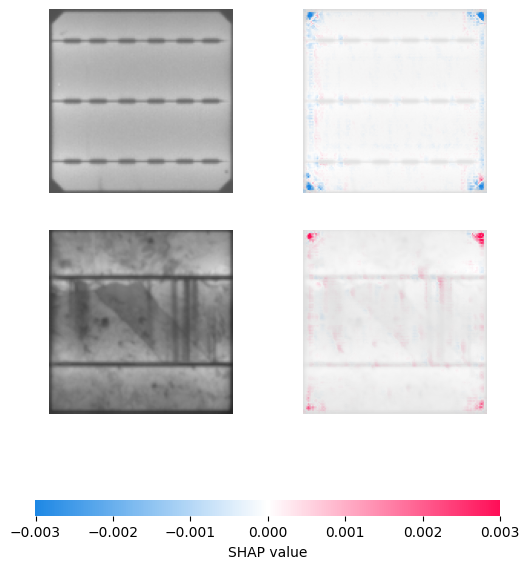

In [45]:
# plot SHAP values
# plot_actual_predicted(images_dict, predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class)

In [47]:
# Example image for the first class in the test set
x_test_example = X_test[2].reshape((1, 120, 120, 3))


In [48]:
# Compute predictions for the example
predictions_example = model.predict(x_test_example)

1/1 [==============================] - 0s 104ms/step


In [49]:
# Compute SHAP values for the example
shap_values_example = explainer.shap_values(x_test_example)

# Print the predicted class for the example
predicted_class_example = np.argmax(predictions_example, axis=1)
print(f"Predicted Class: {predicted_class_example[0]}")

# 3 is the best example to understand this

Predicted Class: 0


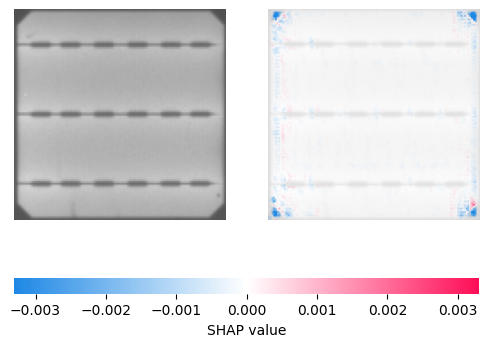

In [50]:
# Plot the SHAP values over the image
shap.image_plot(shap_values_example, x_test_example)
# Show the plot
plt.show()